# Logística de envíos: ¿Cuándo llega?

## Mentoría DiploDatos 2019 

### Integrantes:

- Chaves, Noelia
- Frau, Johanna

### Mentora:

- Dal Lago, Virginia

### Práctico: Introducción al aprendizaje automático

## Motivación

En la actualidad, cada vez más productos se comercializan a través de una plataforma online. Una de las principales ventajas de este sistema es que el usuario puede recibir el producto en su domicilio en una fecha determinada. Pero, ¿cómo sabemos qué día va a llegar? ¿A partir de qué datos podemos predecir la demora del envío? En este práctico se trabajará con datos de envíos de MercadoLibre, el e-commerce más grande de Latinoamérica, analizando y modelando el problema de logística de envíos para poder responder ¿cuándo llega?

## Descripción del dataset

**Datos:**  El conjunto de datos seleccionado para realizar el práctico corresponde a un muestreo aleatorio no uniforme de 500.000 envíos de MercadoLibre. Estos envíos fueron realizados en Brasil en el período comprendido entre Octubre de 2018 y Abril de 2019 (las fechas originales han sido modificadas y adaptadas a un período de tiempo diferente, conservando el día de la semana y considerando los feriados correspondientes). Mientras que las fechas han sido modificadas, los horarios registrados en el dataset son los originales. Los datos comprenden variables tanto categóricas como numéricas. 

El dataset cuenta con las siguientes columnas:

- **Sender_state:** Estado de Brasil de donde sale el envío.
- **Sender_zipcode:** Código postal (de 5 dígitos) de donde sale el envío.
- **Receiver_state:** Estado de Brasil a donde llega el envío.
- **Receiver_zipcode:** Código postal (de 5 dígitos) a donde llega el envío.
- **Shipment_type:** Método de envío (normal, express, super).
- **Quantity:** Cantidad de productos en un envío.
- **Service:** Servicio del correo con el cual se realizó un envío.
- **Status:** Estado del envío (set: listo para ser enviado, sent: enviado, done: entregado, failed: no entregado, cancelled: cancelado).
- **Date_created:** Fecha de creación del envío.
- **Date_sent:** Fecha y hora en que se realizó el envío (salió del correo).
- **Date_visit:** Fecha y hora en que se entregó el envío al destinatario.
- **Shipment_days:** Días hábiles entre que el envío fue enviado (salió del correo) y que fue entregado.




## Objetivos generales

  * Realizar de manera completa el proceso de desarrollo de un modelo de aprendizaje automático para determinar cuándo llega un envío.
  * Desarrollar el conocimiento práctico sobre dicho proceso, desde la definición de los datasets, la elección y análisis del modelo y las métricas propias para la problemática.
  * Desarrollar habilidades de comunicación de la información obtenida a partir de los datos de manera clara y sencilla.

## Objetivos específicos

    *
    *
    *


## Desarrollo del trabajo

In [1]:
import matplotlib.pyplot as plt
import numpy 
import pandas
import seaborn


from IPython.display import HTML
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

### Lectura y análisis inicial de los datos

In [2]:
url = "https://raw.githubusercontent.com/cnoeliachaves/csv/master/dataset_sample_corrected.csv"

dataset = pandas.read_csv(url, dtype={'sender_zipcode':'int64',
                              'receiver_zipcode':'int64',
                              'quantity':'int64',
                              'service':'int64'},
                       parse_dates=['date_created','date_sent','date_visit'])
dataset.shape

(500000, 12)

In [3]:
numpy.random.seed(0) #con propositos de reproducibilidad
#dataset.sample(10)

### Limpieza de datos

En esta sección retomaremos algunos puntos del práctico anterior con el objetivo de limpiar nuestro dataset.

**Shipment day anómalos**

En primer lugar, eliminaremos los valores de shipment days negativos.

In [4]:
def clean_shipment_days(dataset):
    """Le saco los valores negativos"""
    shipments_days = dataset['shipment_days']
    mask = (shipments_days >= 0)
    return dataset[mask]

In [5]:
dataset_clean = clean_shipment_days(dataset)

**Datos duplicados**

Como se observo en el práctico anterior nuestro conjunto de datos contaba con 6469 filas de información duplicada las cuales procederemos a eliminar a continuación. 

In [6]:
dataset_clean = dataset_clean.drop_duplicates()

**Fechas anómalas**

En el análisis realizado en el práctico anterior de las 3 variables con información de fechas y horas encontramos que la variable date_created cuenta con valores que caen fuera del intervalo temporal considerado y que todos ellos se encuentran ubicados en el mes de Junio de 2019. Luego de haber realizado una inspección de esta información anómala llegamos a la conclusión que los mismos podrían deberse a un error en el proceso de carga y que en realidad son datos de Enero de 2019. 

Siguiendo esta idea decidimos en este momento subsanar este posible error de carga haciendo que la información de la variable date_created correspondiente al mes de Junio de 2019 sea ahora del mes de Enero de 2019.

In [7]:
date_created_junio = dataset_clean[dataset_clean['date_created'].map(lambda x: x.month) == 6]
#date_created_junio

In [8]:
from datetime import timedelta

date_created_junio = dataset_clean['date_created'].map(lambda x: x+timedelta(days=-151) if x.month==6 else x) 
date_created_junio
dataset_clean['date_created'] = date_created_junio

In [9]:
dataset_clean['date_created'].dt.month.unique()

array([ 3,  2,  1,  4, 12, 10, 11], dtype=int64)

In [10]:
dataset_clean.describe(include='datetime64')

,date_created,date_sent,date_visit
count,492881,492881,492881
unique,124,81276,55668
top,2019-03-05 00:00:00,2019-03-11 15:53:00,2019-03-11 22:00:00
freq,20169,112,607
first,2018-10-21 00:00:00,2018-10-23 13:57:00,2019-02-25 05:36:00
last,2019-04-29 00:00:00,2019-03-29 01:46:20,2019-04-02 15:35:00


### La importancia de predecir el valor de la variable shipment_days

Uno de los objetivos principales del análisis propuesto en esta mentoría es predecir (dar un número aproximado de días hábiles) de cuanto va a tardar en llegar un envío desde que el cliente realiza la compra a través de la plataforma de Mercado Libre hasta que el paquete llega a su casa. Dicha predicción es importante porque es la que recibe el cliente y es la que determinará en una buena proporción la experiencia del usuario dentro la plataforma.

Esto nos lleva a pensar que dicha predicción se parecerá a los valores de la variable shipment_days con, quizás, 1 o 2 días más de diferencia. Pues este último feature cuenta el intervalo de días entre date_sent y date_visit y nosotros necesitamos dar la aproximación a partir del momento de la compra. Por lo tanto este sería el target de un algoritmo de aprendizaje automático. Si bien este feature originalmente es información de tipo numérica en el práctico anterior utilizamos enconding para convertirla en una variable categórica. Así, esto nos da la posibilidad de trabajar con diferentes modelos de aprendizaje automático utilizando el mismo feature como target pero en sus diferentes versiones.

Frente a este problema consideramos que el estado de Brasil que recibe el envío (receiver_state) es un feature importante a tener en cuenta (mientras más lejos esté de San Pablo probablemente demore más) y probablemente también el código postal de dicho estado (receiver_zipcode). Por otro lado, el tipo de correo (service) también puede ser una variable importante a tener en cuenta porque la calidad de servicio impactará directamente en los días que tarda en llegar el pedido.



In [34]:
#dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492881 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        492881 non-null object
sender_zipcode      492881 non-null int64
receiver_state      492881 non-null object
receiver_zipcode    492881 non-null int64
shipment_type       492881 non-null object
quantity            492881 non-null int64
service             492881 non-null int64
status              492881 non-null object
date_created        492881 non-null datetime64[ns]
date_sent           492881 non-null datetime64[ns]
date_visit          492881 non-null datetime64[ns]
shipment_days       492881 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 48.9+ MB


Luego de haber limpiado nuestro dataset observamos que contamos con 492881 filas con información, es decir la limpieza solo afectó al 1,42% de los datos originales.



### Conjunto de entrenamiento y validación

Debido a la naturaleza de nuestro problema, la separación de los datos en un conjunto de entrenamiento y uno de validación no puede hacerse de manera aleatoria. 

Dado que para determinar (predecir) cuando llega un envío estamos teniendo en cuenta diferentes variables de tipo fecha-hora (las cuales al mismo tiempo tienen una cierta dependencia entre sí), la partición de nuestros datos debe hacerse en función de ellas. Particularmente, debemos entrenar nuestro modelo hasta una determinada fecha de la variable date_visit (la cual debe escogerse con algún criterio) y evaluar el mismo con  datos donde la variable date_created sea mayor que la variable date_visit elegida previamente.

A continuación presentamos un pequeño análisis que nos ayudará a elegir la última fecha de date_visit con la cual entrenaremos nuestros datos.


In [11]:
dataset_clean['date_created_only_date'] = dataset_clean['date_created'].dt.date

In [12]:
#creamos una nueva columna donde date_visit solo considera las fechas
dataset_clean['date_visit_only_date'] = dataset_clean['date_visit'].dt.date

Según podemos observar en los cálculos de arriba la variable date_visit  abarca desde el 25-02-2019 al 02-04-2019.

Veamos ahora como se distribuyen estos datos dentro de este intervalo temporal.

Considerando que nuestro dataset cuenta en este momento con 492881 entradas, el 70% del mismo representa aproximadamente 345000 entradas. Así, de acuerdo a la distribución mostrada arriba si entrenamos nuestro modelo con datos de la variable date_visit hasta el 20 de marzo podriamos llegar a cubrir este porcentaje.

Esto se muestra a continuación.

Finalmente con el filtro aplicado nuestro conjunto de entrenamiento cuenta con 345348 entradas.

In [13]:
#dataset_clean.reset_index(drop=True)
mask1 = (dataset_clean['date_visit'].dt.month==2) | ((dataset_clean['date_visit'].dt.day<=20) & (dataset_clean['date_visit'].dt.month==3))
mask2 = (dataset_clean['date_created'].dt.month==4) | ((dataset_clean['date_created'].dt.day>20) & (dataset_clean['date_created'].dt.month==3))

In [33]:
#dataset_clean[mask1&mask2].index

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Int64Index([], dtype='int64')

In [14]:
dataset_clean.drop(dataset_clean[mask1&mask2].index, inplace = True)

In [15]:
dataset_clean.shape

(492849, 14)

In [16]:
dataset_clean.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,date_created_only_date,date_visit_only_date
0,SP,1039,SP,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,2019-03-10,2019-03-18
1,SP,3004,PB,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,2019-03-08,2019-03-18
2,SP,3262,RJ,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,2019-02-21,2019-03-01
3,SP,12237,SP,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,2019-02-25,2019-03-07
4,SP,9350,AP,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,2019-02-15,2019-03-11


In [163]:
#dataset_clean.set_index("date_visit", inplace=True)

In [180]:
dataset_clean.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,date_created_only_date,date_visit_only_date
0,SP,1039,SP,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,2019-03-10,2019-03-18
1,SP,3004,PB,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,2019-03-08,2019-03-18
2,SP,3262,RJ,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,2019-02-21,2019-03-01
3,SP,12237,SP,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,2019-02-25,2019-03-07
4,SP,9350,AP,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,2019-02-15,2019-03-11


In [17]:
df_train = dataset_clean.loc[((dataset_clean["date_visit"].dt.month==3) & (dataset_clean['date_visit'].dt.day<=20)) | (dataset_clean["date_visit"].dt.month==2)]

In [18]:
X_train = df_train[['receiver_zipcode','service']]

In [19]:
y_train = df_train[['shipment_days']]

In [20]:
df_test = dataset_clean.loc[(dataset_clean['date_created'].dt.month==4) | ((dataset_clean['date_created'].dt.day>20) & (dataset_clean['date_created'].dt.month==3))]

In [21]:
X_test = df_test[['receiver_zipcode','service']]

In [22]:
y_train.values

array([[5.],
       [5.],
       [4.],
       ...,
       [2.],
       [0.],
       [9.]])

In [23]:
y_test = df_test[['shipment_days']]

In [24]:
dataset_clean.shape

(492849, 14)

In [205]:
dataset_clean.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days,date_created_only_date,date_visit_only_date
0,SP,1039,SP,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,5.0,2019-03-10,2019-03-18
1,SP,3004,PB,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,5.0,2019-03-08,2019-03-18
2,SP,3262,RJ,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,4.0,2019-02-21,2019-03-01
3,SP,12237,SP,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2.0,2019-02-25,2019-03-07
4,SP,9350,AP,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,13.0,2019-02-15,2019-03-11


In [201]:
dataset_clean.columns

Index(['sender_state', 'sender_zipcode', 'receiver_state', 'receiver_zipcode',
       'shipment_type', 'quantity', 'service', 'status', 'date_created',
       'date_sent', 'date_visit', 'shipment_days', 'date_created_only_date',
       'date_visit_only_date'],
      dtype='object')

In [235]:
X_train.head()

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,date_created_only_date,date_visit_only_date
0,SP,1039,SP,14500,standard,1,1,done,2019-03-10,2019-03-11 14:34:00,2019-03-18 09:52:00,2019-03-10,2019-03-18
1,SP,3004,PB,58670,standard,1,1,done,2019-03-08,2019-03-09 10:48:00,2019-03-18 15:16:00,2019-03-08,2019-03-18
2,SP,3262,RJ,22723,standard,1,2,done,2019-02-21,2019-02-23 02:02:16,2019-03-01 21:27:00,2019-02-21,2019-03-01
3,SP,12237,SP,18682,standard,1,2,done,2019-02-25,2019-02-28 03:05:36,2019-03-07 15:01:00,2019-02-25,2019-03-07
4,SP,9350,AP,68908,standard,1,1,done,2019-02-15,2019-02-15 11:28:00,2019-03-11 13:18:00,2019-02-15,2019-03-11


In [238]:
X_test

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,date_created_only_date,date_visit_only_date
12,SP,13304,SP,15991,express,1,0,done,2019-03-25,2019-03-27 11:33:00,2019-03-28 14:43:00,2019-03-25,2019-03-28
14,SP,13290,DF,70719,super,1,6,done,2019-03-22,2019-03-23 05:44:16,2019-03-25 11:11:49,2019-03-22,2019-03-25
29,SP,1213,RS,92310,express,1,0,done,2019-03-23,2019-03-25 16:05:00,2019-03-28 15:47:00,2019-03-23,2019-03-28
51,SP,3570,SP,7600,express,1,0,done,2019-03-23,2019-03-25 14:33:00,2019-03-27 15:42:00,2019-03-23,2019-03-27
53,SP,1023,SP,3422,super,1,5,done,2019-03-24,2019-03-25 18:14:17,2019-03-26 08:11:29,2019-03-24,2019-03-26
57,SP,11050,SP,9080,express,1,0,done,2019-03-22,2019-03-22 15:37:00,2019-03-25 15:29:00,2019-03-22,2019-03-25
91,SP,8735,SP,2245,express,1,4,done,2019-03-24,2019-03-25 20:37:36,2019-03-29 00:23:00,2019-03-24,2019-03-29
97,SP,2942,SP,15350,express,2,0,done,2019-03-26,2019-03-27 16:16:00,2019-03-28 12:24:00,2019-03-26,2019-03-28
109,SP,13901,RJ,22795,express,1,4,done,2019-03-24,2019-03-25 22:08:11,2019-03-28 12:24:00,2019-03-24,2019-03-28
119,SP,12940,SP,4063,express,1,0,done,2019-03-27,2019-03-27 15:51:00,2019-03-28 14:12:00,2019-03-27,2019-03-28


In [234]:
#y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345316 entries, 0 to 499999
Data columns (total 1 columns):
shipment_days    345316 non-null float64
dtypes: float64(1)
memory usage: 5.3 MB


In [264]:
#y_test.head()

,shipment_days
12,1.0
14,0.0
29,3.0
51,2.0
53,1.0


In [25]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'
from sklearn import tree
import graphviz

In [26]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train.values)

In [27]:
features_names = ["receiver_code","service"]

In [28]:
target_names = ["0-1 dias","2-3 dias","4-5 dias","6-7 dias","8-9 dias","10 o mas dias"]

In [29]:
shipment_days = y_train['shipment_days']
shipment_days_byclass= [None] * len(shipment_days)
for line,row in enumerate(shipment_days):
    if row in (0,1):
        shipment_days_byclass[line] = 1
    elif row in (2,3):
        shipment_days_byclass[line] = 2            
    elif row in (4,5):
        shipment_days_byclass[line] = 4
    elif row in (6,7):
        shipment_days_byclass[line] = 6
    elif row in (8,9):
        shipment_days_byclass[line] = 8
    else:
        shipment_days_byclass[line] = 10

In [30]:
y_train['shipment_days_byclass'] = shipment_days_byclass

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
y_train['shipment_days_byclass']

0          4
1          4
2          4
3          2
4         10
6          2
7          4
8          4
10         1
11         2
15        10
17         1
18         2
19         6
20         2
21         1
22         2
23        10
24         2
26         2
27         6
28         2
30         6
31         1
32         6
33         8
35         8
36        10
37         2
39         4
          ..
499958     2
499960    10
499961     2
499963     8
499964     1
499965     1
499966    10
499967     1
499971     8
499973     2
499974     2
499975     1
499977     1
499979    10
499980     2
499981     8
499982    10
499983     1
499984     2
499985     4
499986    10
499987     6
499988     2
499989     8
499990     8
499991     2
499992     2
499994     2
499997     1
499999     8
Name: shipment_days_byclass, Length: 345316, dtype: int64

In [32]:
shipment_days = y_test['shipment_days']
shipment_days_byclass = [None] * len(shipment_days)
for line,row in enumerate(shipment_days):
    if row in (0,1):
        shipment_days_byclass[line]= 1
    elif row in (2,3):
        shipment_days_byclass[line] = 2
    elif row in (4,5):
        shipment_days_byclass[line] = 4
    elif row in (6,7):
        shipment_days_byclass[line] = 6
    elif row in (8,9):
        shipment_days_byclass[line] = 8
    else:
        shipment_days_byclass[line] = 10

In [33]:
y_test['shipment_days_byclass'] = shipment_days_byclass

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
y_test['shipment_days_byclass'].values

array([1, 1, 2, ..., 2, 1, 2], dtype=int64)

In [35]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train["shipment_days_byclass"])

In [ ]:
# este grafico tira error
#dot_data = tree.export_graphviz(clf, out_file=None, 
#                         feature_names=features_names,  
#                         class_names=target_names,  
#                         filled=True, rounded=True)
#graph = graphviz.Source(dot_data)
#graph

In [36]:
import numpy as np

In [37]:
predictions = clf.predict(X_train)
print ('Accuracy: %d ' % ((np.sum(y_train["shipment_days_byclass"] == predictions))/float(y_train["shipment_days_byclass"].size)*100))

Accuracy: 62 


In [38]:
predictions = clf.predict(X_test)
print ('Accuracy: %d ' % ((np.sum(y_test["shipment_days_byclass"] == predictions))/float(y_test["shipment_days_byclass"].size)*100))

Accuracy: 64 


In [39]:
print("Reporte de clasificación (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test["shipment_days_byclass"], clf.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

Reporte de clasificación (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           1       0.77      0.75      0.76     17959
           2       0.59      0.54      0.56     12582
           4       0.24      0.27      0.25      1455
           6       0.00      0.09      0.00        11
           8       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0

   micro avg       0.64      0.64      0.64     32007
   macro avg       0.27      0.27      0.26     32007
weighted avg       0.68      0.64      0.66     32007




C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [42]:
from ml.visualization import plot_confusion_matrix

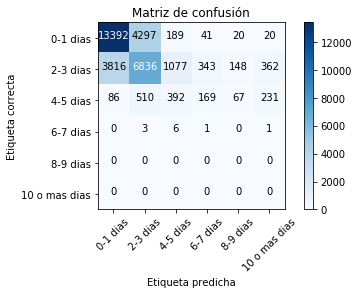

In [43]:
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=target_names, title="Matriz de confusión")

Para las 2 primeras clases anda bien, pero para las demas no tan bien. habria que porbar otro modelo.
Probemos con SGDClassifier

In [45]:
from sklearn.linear_model import SGDClassifier

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Reporte de clasificación para el clasificador (sobre conjunto de evaluación):

              precision    recall  f1-score   support

           1       0.00      0.00      0.00     17959
           2       0.39      1.00      0.56     12582
           4       0.00      0.00      0.00      1455
           6       0.00      0.00      0.00        11

   micro avg       0.39      0.39      0.39     32007
   macro avg       0.10      0.25      0.14     32007
weighted avg       0.15      0.39      0.22     32007



Accuracy of SGDC classifier on training set: 0.29

C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\cintia.chaves\AppData\Local\Continuum\anaconda3\envs\diplodatos\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Accuracy of SGDC classifier on test set: 0.39


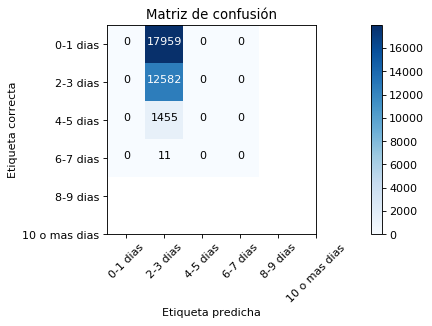

In [48]:
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

m = SGDClassifier()

m.fit(X_train, y_train["shipment_days_byclass"])

print("Reporte de clasificación para el clasificador (sobre conjunto de evaluación):", end="\n\n")
y_true, y_pred = y_test["shipment_days_byclass"], m.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

print("================================================", end="\n\n")

plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=target_names, title="Matriz de confusión")

print('Accuracy of SGDC classifier on training set: {:.2f}' .format(m.score(X_train, y_train["shipment_days_byclass"])))
print('Accuracy of SGDC classifier on test set: {:.2f}'.format(m.score(X_test, y_test["shipment_days_byclass"])))


Probemos con regresión sin regularización

## Utilizando la variable shipment_days en su versión de tipo numérica

## Utilizando la variable shipment_days en su versión de tipo categórica